In [6]:
import numpy as np
import pandas as pd

from datetime import datetime
from scipy.stats import skew 
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import os
print(os.listdir())

import warnings
warnings.filterwarnings('ignore')


['submission.csv', 'Day1.ipynb', 'titanic', 'house-prices-advanced-regression-techniques.zip', 'titanic.zip', 'Untitled.ipynb', 'Day2 Housing Price.ipynb', 'home-data-for-ml-course.zip', '.ipynb_checkpoints', 'home-data-for-ml-course']


In [8]:
train = pd.read_csv('home-data-for-ml-course/train.csv')
test = pd.read_csv('home-data-for-ml-course/test.csv')
print ("Data is loaded!")

Data is loaded!


In [9]:
print ("Train: ",train.shape[0],"sales, and ",train.shape[1],"features")
print ("Test: ",test.shape[0],"sales, and ",test.shape[1],"features")

Train:  1460 sales, and  81 features
Test:  1459 sales, and  80 features


In [10]:
train.shape

(1460, 81)

In [11]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [12]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [14]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

In [16]:
sns.set_style("whitegrid")
missing = train.isnull().sum()
missing

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [17]:
missing = missing[missing > 0]
missing

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

<Axes: >

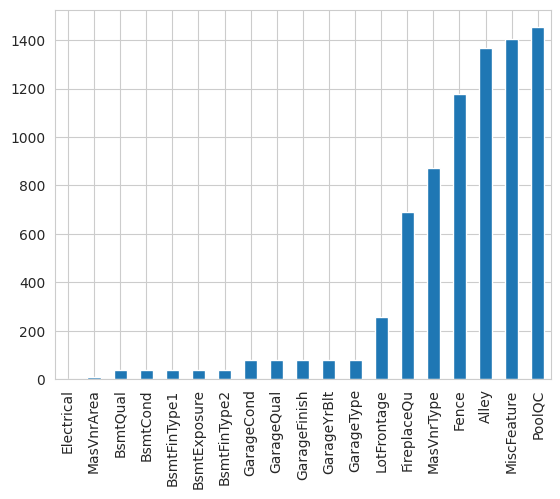

In [18]:
missing.sort_values(inplace=True)
missing.plot.bar()

<Axes: title={'center': 'Log Normal'}, xlabel='SalePrice'>

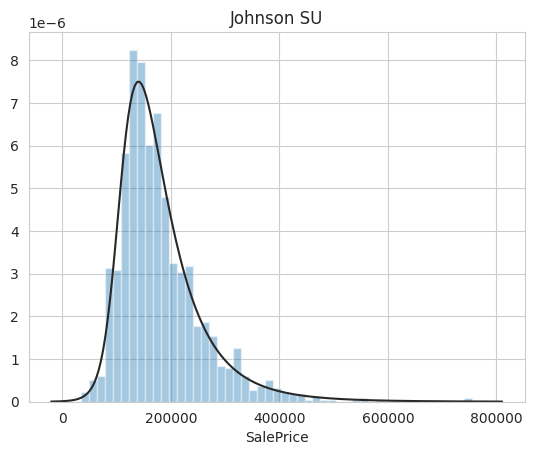

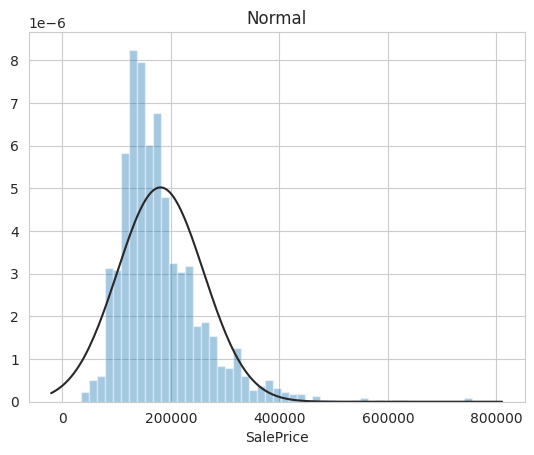

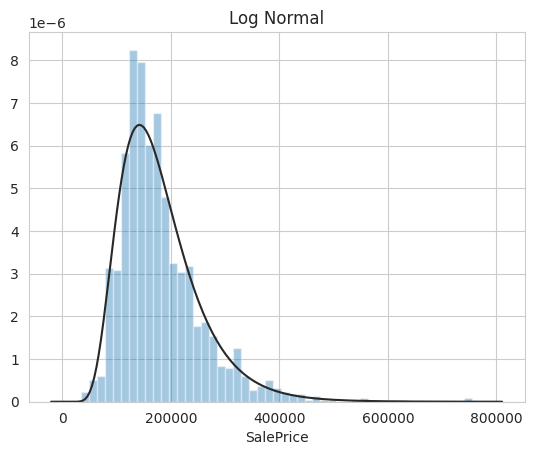

In [22]:
y = train['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

In [23]:
# shapiro-wilk test 正态性检验方法，常用，准确性高，适合小样本量
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


In [100]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(train, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


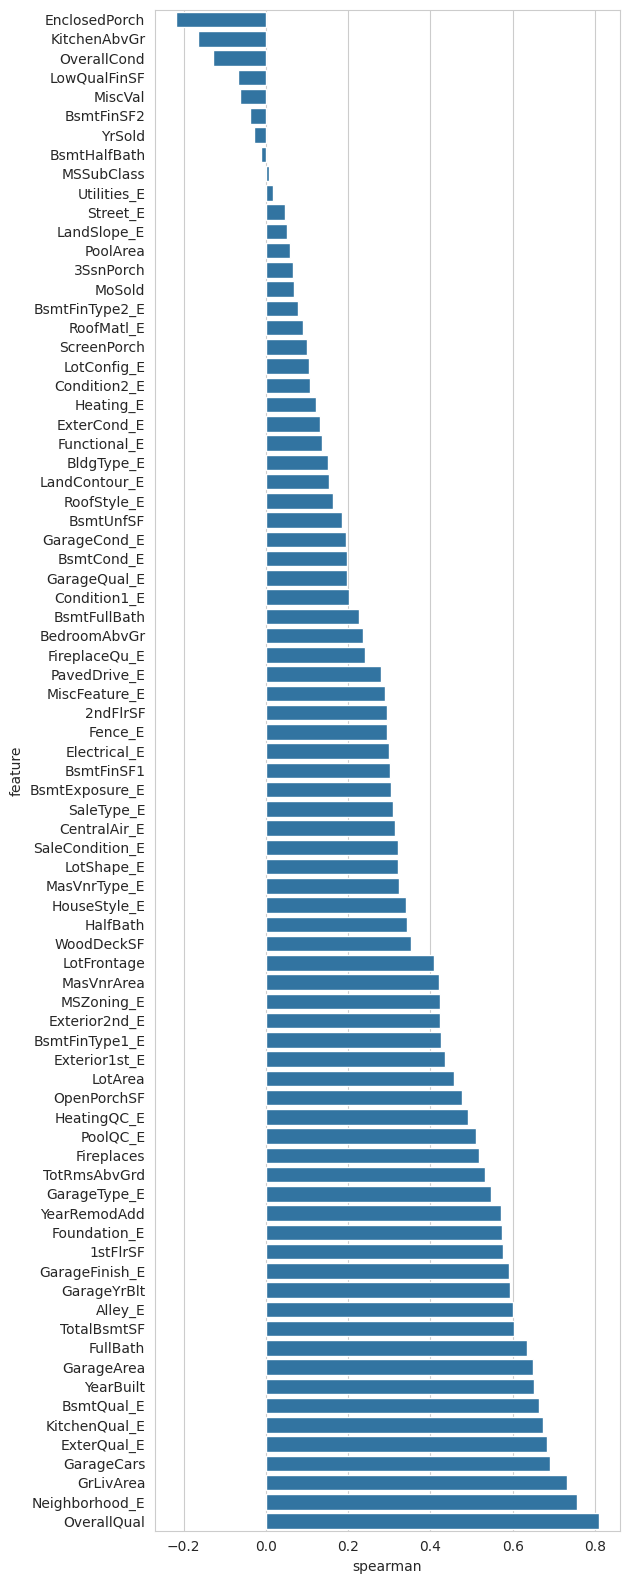

In [32]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qual_encoded
spearman(train, features)

<Axes: >

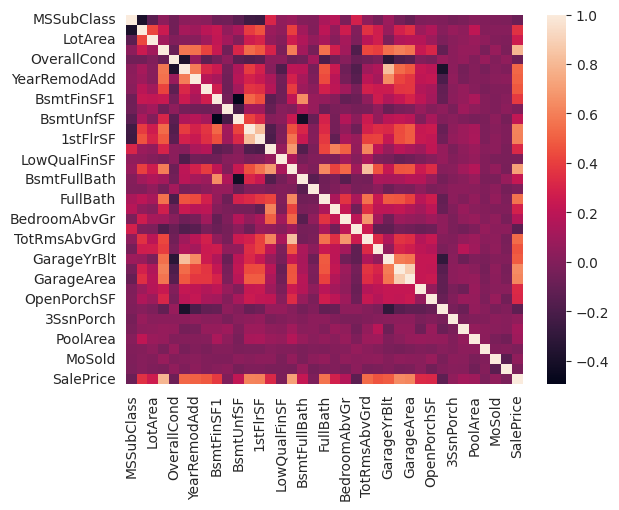

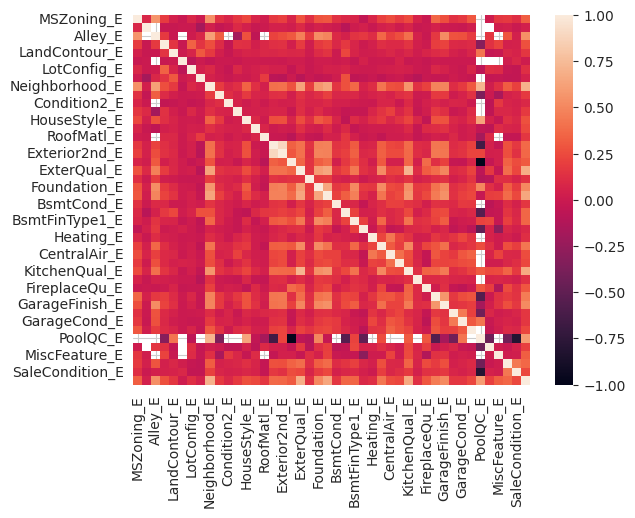

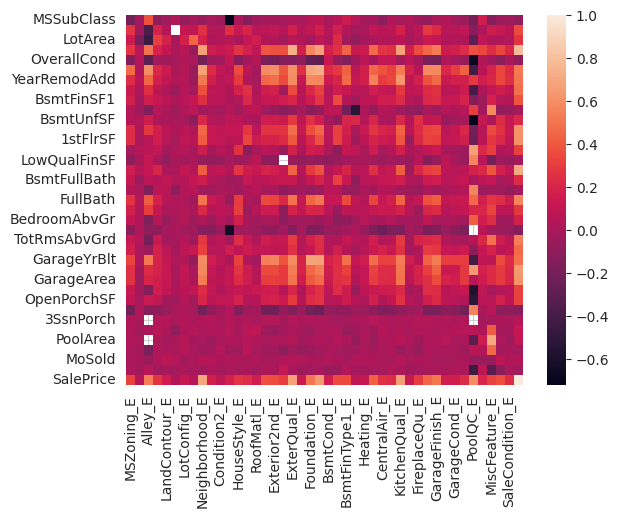

In [33]:
plt.figure(1)
corr = train[quantitative+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(2)
corr = train[qual_encoded+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(3)
# 设置空矩阵，用来存放相关系数值
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['SalePrice'], columns=qual_encoded+['SalePrice'])
for q1 in quantitative+['SalePrice']:
    for q2 in qual_encoded+['SalePrice']:
        # 将相关系数存在刚才的空矩阵指定位置，df.loc['row_label1', 'row_label2'] 
        corr.loc[q1, q2] = train[q1].corr(train[q2])
sns.heatmap(corr)

0.7567219242750316


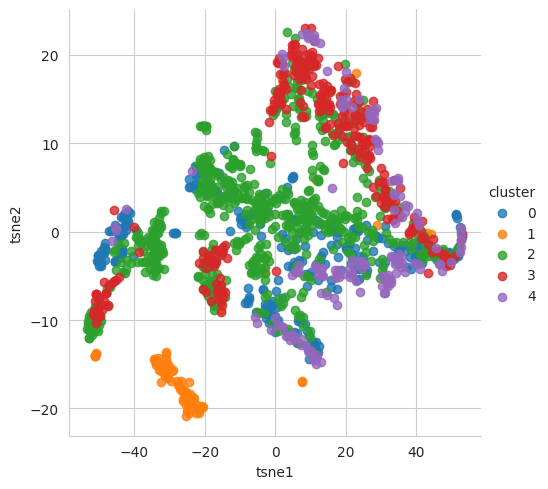

In [34]:
features = quantitative + qual_encoded
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = train[features].fillna(0.).values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=30)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

0.999999973925913


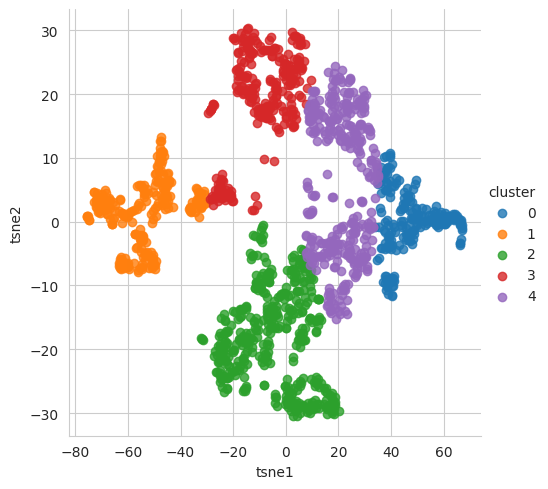

In [70]:
# 原来是直接用原始 X 做 t-SNE
X = train[features].fillna(0.).values

# 优化：先用 PCA 降到 50 维再送给 t-SNE（加速 + 降噪）
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

tsne = TSNE(n_components=2, perplexity=30, random_state=0)
X_tsne = tsne.fit_transform(X_pca)

kmeans = KMeans(n_clusters=5)
kmeans.fit(X_tsne)

fr = pd.DataFrame({'tsne1': X_tsne[:,0], 'tsne2': X_tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

In [71]:
print(pca.explained_variance_ratio_)

[9.82802193e-01 5.08478664e-03 3.38579262e-03 2.77709234e-03
 2.41016299e-03 1.96561328e-03 4.99488558e-04 3.06752228e-04
 2.57240200e-04 1.83034077e-04 1.38398765e-04 4.10015216e-05
 3.32816656e-05 3.02153561e-05 2.75992803e-05 1.59470746e-05
 1.50604502e-05 9.29572548e-06 8.35713961e-06 6.04270531e-06
 2.01877762e-06 1.72116163e-07 1.07839932e-07 7.13173217e-08
 2.68278851e-08 2.27809948e-08 1.74696424e-08 1.62264470e-08
 1.44463344e-08 1.25837524e-08 1.24599610e-08 1.14098684e-08
 1.11662959e-08 1.04446628e-08 9.80951850e-09 9.47194068e-09
 8.91903714e-09 8.42084112e-09 7.86428931e-09 6.50059141e-09
 6.02654690e-09 5.91674829e-09 4.98935719e-09 4.84120237e-09
 4.73160777e-09 3.62845518e-09 3.16710417e-09 2.89425451e-09
 2.62293712e-09 2.37421676e-09]


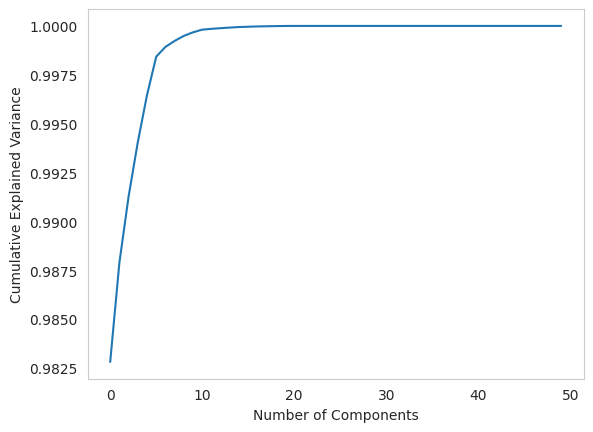

In [72]:
import matplotlib.pyplot as plt
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()


In [73]:
import umap.umap_ as umap
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
f_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_pca)
f_umap = f_reducer.fit_transform(X)

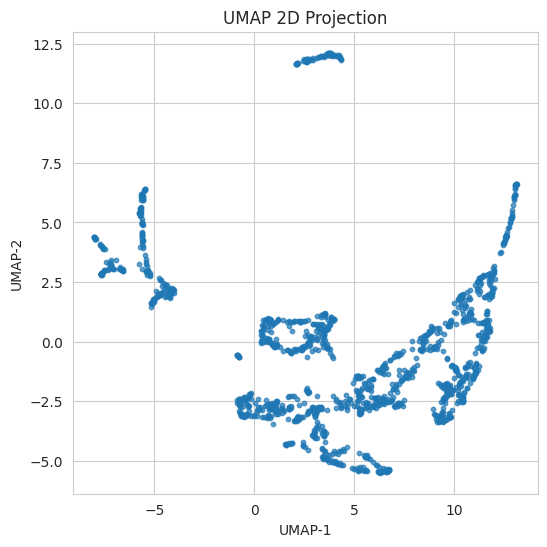

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=10, alpha=0.7)
plt.title("UMAP 2D Projection")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()



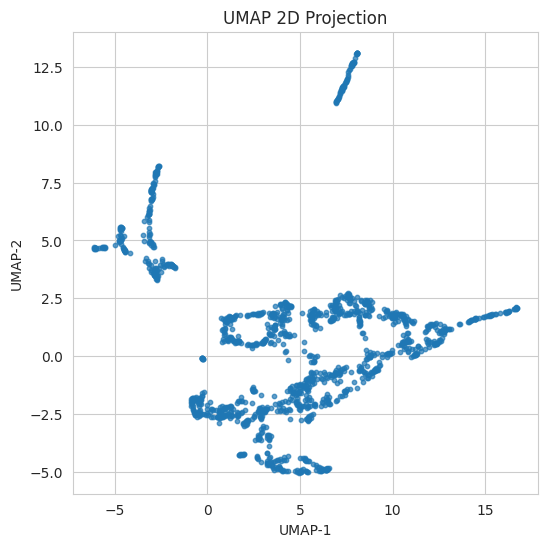

In [75]:

plt.figure(figsize=(6,6))
plt.scatter(f_umap[:, 0], f_umap[:, 1], s=10, alpha=0.7)
plt.title("UMAP 2D Projection")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()

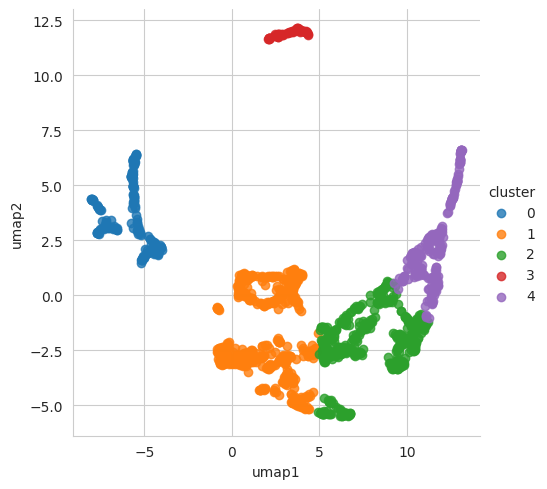

In [91]:
X_kmeans = KMeans(n_clusters=5, random_state=0)
X_kmeans.fit(X_umap)
fr = pd.DataFrame({'umap1': X_umap[:,0], 'umap2': X_umap[:, 1], 'cluster': X_kmeans.labels_})
sns.lmplot(data=fr, x='umap1', y='umap2', hue='cluster', fit_reg=False)

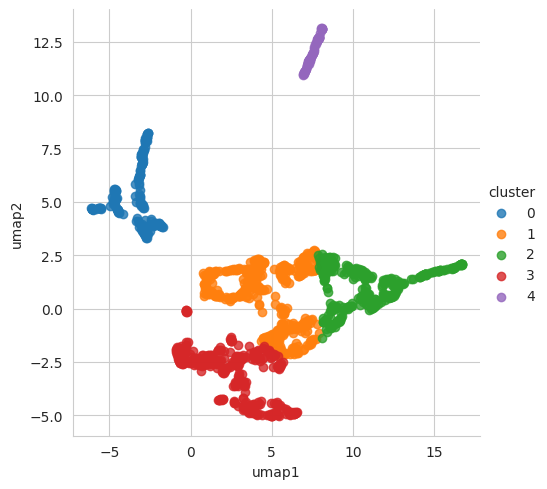

In [92]:
f_kmeans = KMeans(n_clusters=5, random_state=0)
f_kmeans.fit(f_umap)
fr = pd.DataFrame({'umap1': f_umap[:,0], 'umap2': f_umap[:, 1], 'cluster': f_kmeans.labels_})
sns.lmplot(data=fr, x='umap1', y='umap2', hue='cluster', fit_reg=False)

In [93]:
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(X_kmeans.labels_, f_kmeans.labels_)
print(" vs 聚类一致性 ARI:", ari)

 vs 聚类一致性 ARI: 0.46068589307975866


In [94]:
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(X_kmeans.labels_, kmeans.labels_)
print(" vs 聚类一致性 ARI:", ari)

 vs 聚类一致性 ARI: 0.5402962522784108


In [95]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_umap, f_kmeans.labels_)
print(f"UMAP聚类 Silhouette Score: {score:.4f}")


UMAP聚类 Silhouette Score: 0.4022


In [99]:
print(X.shape[0])
print(len(X_kmeans.labels_))
print(type(X_kmeans))

1460
1460
<class 'sklearn.cluster._kmeans.KMeans'>


In [102]:
train['Cluster'] = X_kmeans.labels_

# 查看每个簇在关键变量上的均值
summary = train.groupby('Cluster')[['SalePrice', 'GrLivArea', 'OverallQual', 'YearBuilt']].mean()
print(summary)


             SalePrice    GrLivArea  OverallQual    YearBuilt
Cluster                                                      
0        143389.515982  1260.187215     5.926941  1969.493151
1        164025.807615  1409.444890     5.893788  1971.138277
2        198003.393593  1605.981693     6.352403  1975.263158
3        102171.830986  1162.549296     4.577465  1939.577465
4        244068.722222  1918.495726     6.688034  1975.358974


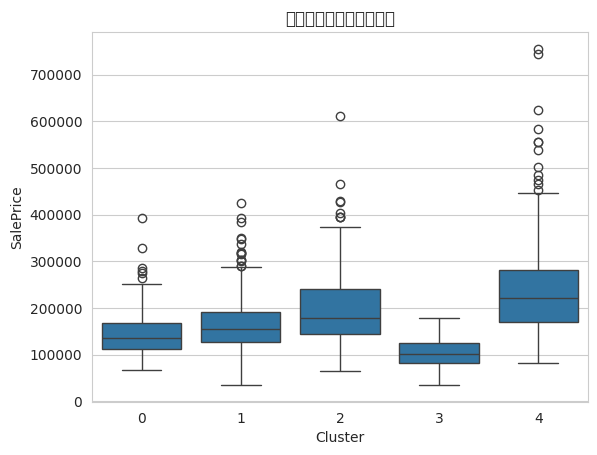

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='Cluster', y='SalePrice', data=train)
plt.title('房价在不同聚类中的分布')
plt.show()


In [104]:
print(train['Cluster'].value_counts())

Cluster
1    499
2    437
4    234
0    219
3     71
Name: count, dtype: int64


In [ ]:
X['X_umap'] = X_kmeans.labels_

Train set size: (1460, 81)
Test set size: (1459, 80)
START data processing 2025-07-06 14:37:34.900172
(2917, 79)


BracketError: The algorithm terminated without finding a valid bracket. Consider trying different initial points.